# Accessing cloud satellite data

- Funding: Interagency Implementation and Advanced Concepts Team [IMPACT](https://earthdata.nasa.gov/esds/impact) for the Earth Science Data Systems (ESDS) program and AWS Public Dataset Program
  
### Credits: Tutorial development
* [Dr. Chelle Gentemann](mailto:gentemann@faralloninstitute.org) -  [Twitter](https://twitter.com/ChelleGentemann)   - Farallon Institute

### Satellite data

Satellite data come from either polar or low inclination orbits that circle the Earth or geostationary orbits that hold a location above a specific location on the Earth, near the Equator.  The type of data from satellites depends on both the orbit and the type of instrument.  There are definitions for the different satellite data types.
- L1 - satellite observations, usually each observation has a lat/lon/time associated with it
- L2 - derived geophysical retrievals (eg. SST), still with lat/lon/time
- L3 - variables mapped to a uniform space/time grid
- L4 - model output or analysis of data, may include multiple sensors

There are several different formats that satellite data:  [netCDF](https://www.unidata.ucar.edu/software/netcdf/), [HDF5](https://www.hdfgroup.org/solutions/hdf5/), and [geoTIFF](https://earthdata.nasa.gov/esdis/eso/standards-and-references/geotiff).
There are also som newer cloud optimized formats that data: [Zarr](https://zarr.readthedocs.io/en/stable/), Cloud Optimized GeoTIFF ([COG](https://www.cogeo.org/)).

### Understand the data
Data access can be easy and fast on the cloud, but to avoid potential issues down the road, spend time to understand the strengths and weaknesses of any data.  Any science results will need to address uncertainties in the data, so it is easier to spend time at the beginning to understand them and avoid data mis-application.

#### This tutorial will focus on netCDF/HDF5/Zarr

### Data proximate computing
These are BIG datasets that you can analyze on the cloud without downloading the data.  
You can run this on your phone, a Raspberry Pi, laptop, or desktop.   
By using public cloud data, your science is reproducible and easily shared!

The OHW Jupyter Hub is a m5.2xlarge instance shared by up to 4 users.  What does that mean?  [m5.2xlarge](https://aws.amazon.com/ec2/instance-types/m5/) has 8 vCPU and 32 GB memory.
If there are 3 other users on your node, then the memory could be used up fast by large satellite datasets, so just be a little aware of that when you want to run something....

### Here we will demonstrate some ways to access the different SST datasets on AWS:
- AWS MUR sea surface temperatures  (L4)
- AWS GOES sea surface temperatures  (L2)
- AWS Himawari sea surface temperatures (L2 and L3)
- ERA5 data (L4)

### To run this notebook

Code is in the cells that have <span style="color: blue;">In [  ]:</span> to the left of the cell and have a colored background

To run the code:
- option 1) click anywhere in the cell, then hold `shift` down and press `Enter`
- option 2) click on the Run button at the top of the page in the dashboard

Remember:
- to insert a new cell below press `Esc` then `b`
- to delete a cell press `Esc` then `dd`

### First start by importing libraries


# How to find an AWS Public Dataset

- Click here: [AWS Public Dataset](https://aws.amazon.com/opendata/)




-------------------------------------------------------





- Click on `Find public available data on AWS` button
- Search for MUR
- Select [MUR SST](https://registry.opendata.aws/mur/)

 
 
 
 

-------------------------------------------------------

![](./awsmur.png)










## [MUR SST](https://podaac.jpl.nasa.gov/Multi-scale_Ultra-high_Resolution_MUR-SST) [AWS Public dataset program](https://registry.opendata.aws/mur/) 

### Access the MUR SST Zarr store which is in an s3 bucket.  

![image](https://podaac.jpl.nasa.gov/Podaac/thumbnails/MUR-JPL-L4-GLOB-v4.1.jpg)

We will start with my favorite Analysis Ready Data (ARD) format: [Zarr](https://zarr.readthedocs.io/en/stable/).  Using data stored in Zarr is fast, simple, and contains all the metadata normally in a netcdf file, so you can figure out easily what is in the datastore.  

- Fast - Zarr is fast because all the metadata is consolidated into a .json file.  Reading in massive datasets is lightning fast because it only reads the metadata and does read in data until it needs it for compute.

- Simple - Filenames?  Who needs them? Who cares?  Not I.  Simply point your read routine to the data directory.

- Metadata - all you want!

In [26]:
# filter some warning messages
import warnings 
warnings.filterwarnings("ignore") 

#libraries
import datetime as dt
import xarray as xr
import fsspec
import s3fs
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# make datasets display nicely
xr.set_options(display_style="html")  

#magic fncts #put static images of your plot embedded in the notebook
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'


[fsspec.get_mapper](https://filesystem-spec.readthedocs.io/en/latest/api.html?highlight=get_mapper#fsspec.get_mapper) Creates a mapping between your computer and the s3 bucket.  This isn't necessary if the Zarr file is stored locally.

[xr.open_zarr](http://xarray.pydata.org/en/stable/generated/xarray.open_zarr.html) Reads a Zarr store into an Xarray dataset


In [27]:
%%time
file_location = 's3://mur-sst/zarr'

ikey = fsspec.get_mapper(file_location, anon=True)

ds_sst = xr.open_zarr(ikey,consolidated=True)

ds_sst

CPU times: user 5.51 s, sys: 138 ms, total: 5.65 s
Wall time: 24.8 s


,Array,Chunk
Bytes,16.70 TB,257.72 MB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,16.70 TB,257.72 MB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


### Read entire 10 years of data at 1 point.

Select the ``analysed_sst`` variable over a specific time period, `lat`, and `lon` and load the data into memory.  This is small enough to load into memory which will make calculating climatologies easier in the next step.

CPU times: user 314 ms, sys: 116 ms, total: 430 ms
Wall time: 1.61 s


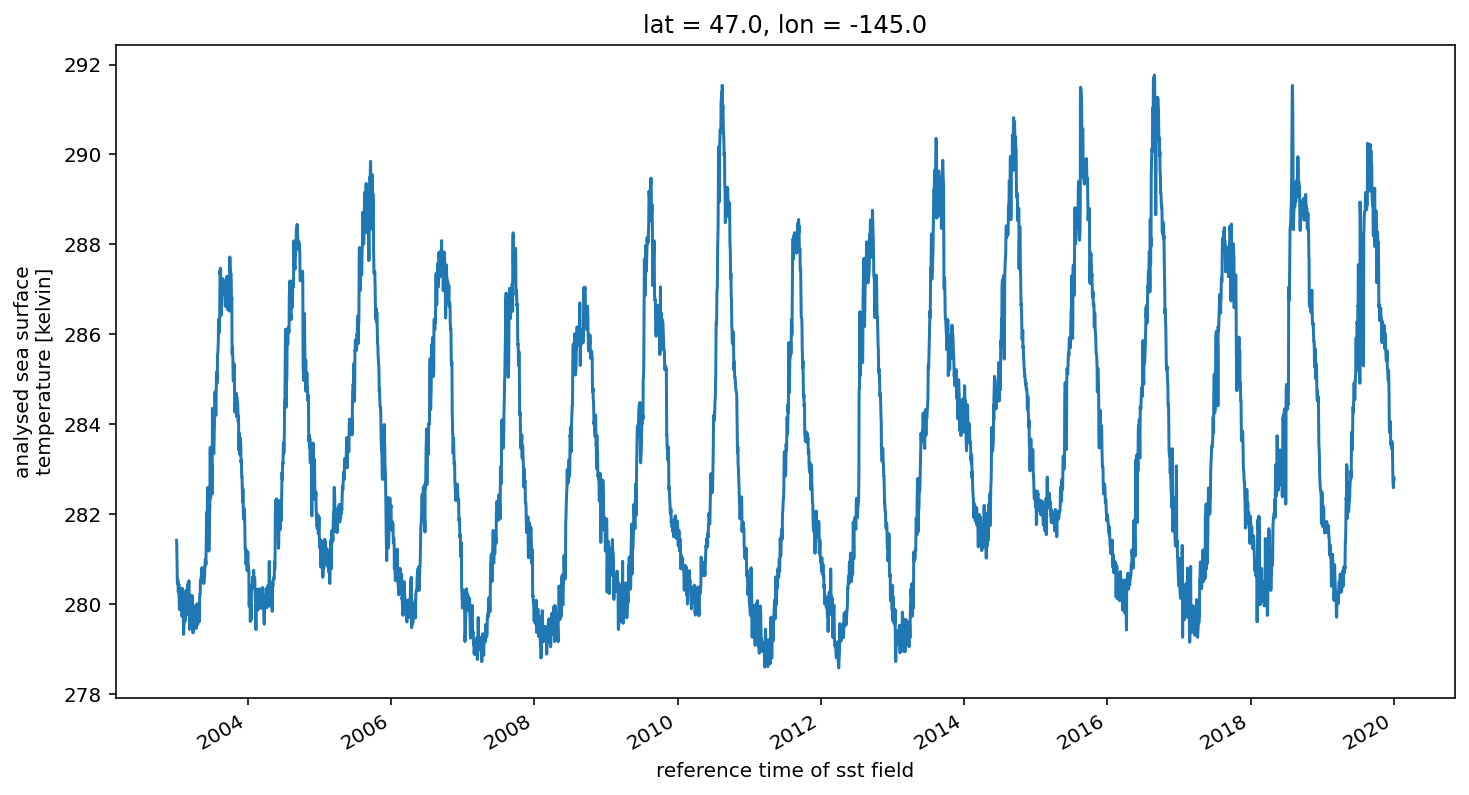

In [28]:
%%time

sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2003-01-01','2020-01-01'),
                                            lat  = 47,
                                            lon  = -145
                                           ).load()

sst_timeseries.plot()

### The anomaly is more interesting...  

Use [.groupby](http://xarray.pydclimatologyata.org/en/stable/generated/xarray.DataArray.groupby.html#xarray-dataarray-groupby) method to calculate the climatology and [.resample](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html#xarray-dataset-resample) method to then average it into 1-month bins.
- [DataArray.mean](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.mean.html#xarray-dataarray-mean) arguments are important! Xarray uses metadata to plot, so keep_attrs is a nice feature.  Also, for SST there are regions with changing sea ice.  Setting skipna = False removes these regions. 

CPU times: user 555 ms, sys: 2.63 ms, total: 558 ms
Wall time: 550 ms


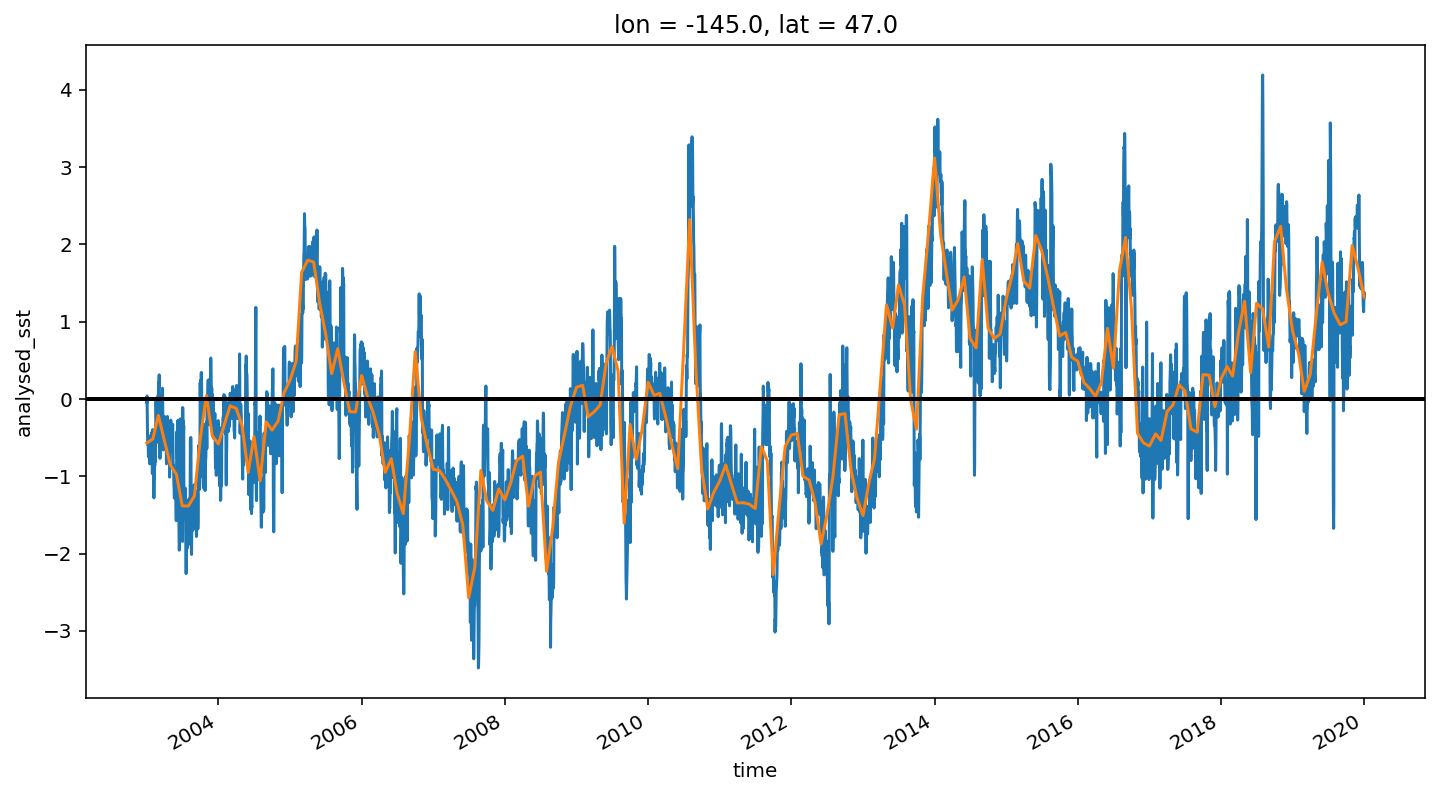

In [29]:
%%time

sst_climatology = sst_timeseries.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)

sst_anomaly = sst_timeseries.groupby('time.dayofyear')-sst_climatology

sst_anomaly_monthly = sst_anomaly.resample(time='1MS').mean(keep_attrs=True,skipna=False)

#plot the data
sst_anomaly.plot()
sst_anomaly_monthly.plot()
plt.axhline(linewidth=2,color='k')

# Chukchi Sea SST timeseries

# Note SST is set to -1.8 C (271.35 K) when ice is present

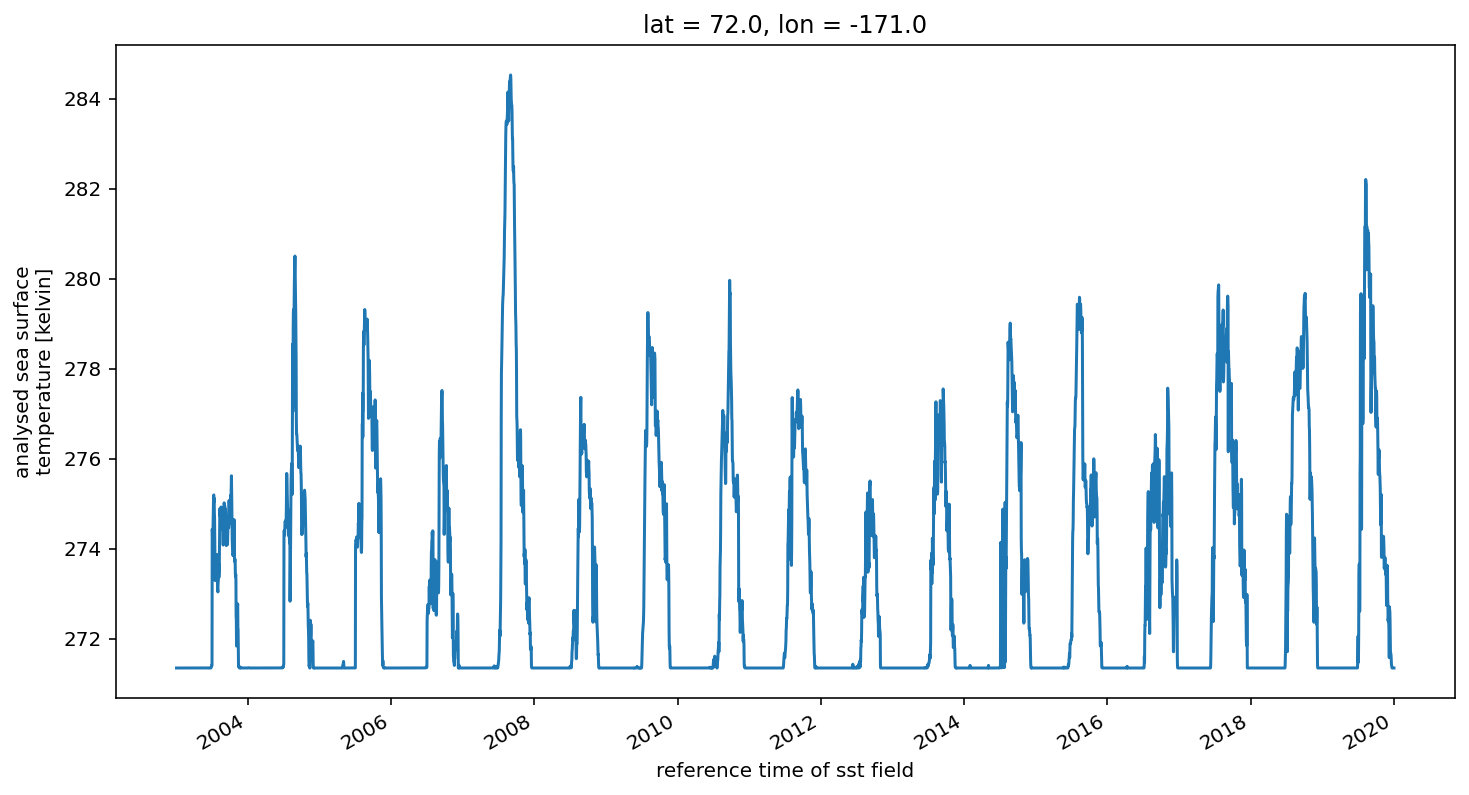

In [30]:
sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2003-01-01','2020-01-01'),
                                            lat  = 72,
                                            lon  = -171
                                           ).load()

sst_timeseries.plot()

In [41]:
xr.Dataset({'series':sst_timeseries}).to_zarr('analysed-72--171', consolidated=True)

In [42]:
%%time
file_location = 's3://ohw-bucket/analysed-72--171'

ikey = fsspec.get_mapper(file_location, anon=False)

ds_bucket = xr.open_zarr(ikey,consolidated=False)


KeyError: '.zmetadata'